<font size="5"><h1>Capstone Project - The Battle of the Neighborhoods (Week 2)</h1></font>
<font size="2"><h2>Applied Data Science Capstone by IBM/Coursera</h2></font>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

This project serves to find the best location for a restaurant to be opened by an 
entrepreneur or an organisation . The project focuses on stakeholders who are interested in an opening an **Italian restaurant** in **New York City**, USA.

The main idea is to target  locations that already have a ready market because establishing yourn own market might be difficult and takes long. These are locations where there  restaurants are a common business, particulary Italian Restaurants. Therefore areas with Italian Restaurants being the most common venues are of interest . In addition, areas which are highly populated are to be considered since this increases the chances of a good clientele.Foursquare information is going to be usesd as well as data  science tools to solve this problem.

## Data <a name="data"></a>

The choice for the location of the restaurant will depend on the following factors:
* population values for the boroughs in New York City
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of  Italian restaurants in the neighborhood, if any
* whether an Italian Restaurant is amongst the top most common venues in the neighborhood


These are the data sources that will be used to extract the required information
* The data population data for each borough in New York City (2019 data set) was obtained from the data set found at this web site https://data.beta.nyc/dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/7caac650-d082-4aea-9f9b-3681d568e8a5/download/nyc_zip_borough_neighborhoods_pop.csv"
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* The data set contains borough names, neighborhood names, latitude and longitude values for each neighborhood found at the following sitehttps://cocl.us/new_york_dataset. .

<font size='3'>Now, will start by importing and installing all dependancies that are needed . Some dependancies will be imported as we progress.</font >

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
%matplotlib inline 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
import requests # library to handle requests
from pandas.io.json import json_normalize 
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [5]:
import json # library to handle JSON files

<font size="3"> Download and explore the first dataset</font>

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [6]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

NewYork_data=newyork_data['features']

In [7]:
new_york_data = newyork_data['features']

<font size="3"> Transforming data into a pandas dataframe</font>

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
new_york = pd.DataFrame(columns=column_names)

In [9]:
for data in new_york_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    new_york = new_york.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
new_york.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
new_york.shape

(306, 4)

<font size="3">Now our data is in the form of pandas data frame. It can be seen that there are 306  neighborhoods in New York City.</font>


<font size="3"> Let's import the second dataset with population information and load it into a pandas dataframe</font>

In [190]:
pop_data=pd.read_csv("https://data.beta.nyc/dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/7caac650-d082-4aea-9f9b-3681d568e8a5/download/nyc_zip_borough_neighborhoods_pop.csv"
)
pop_data.head()

,zip,borough,post_office,neighborhood,population,density
0,10001,Manhattan,"New York, NY",Chelsea and Clinton,21102,33959
1,10002,Manhattan,"New York, NY",Lower East Side,81410,92573
2,10003,Manhattan,"New York, NY",Lower East Side,56024,97188
3,10004,Manhattan,"New York, NY",Lower Manhattan,3089,5519
4,10005,Manhattan,"New York, NY",Lower Manhattan,7135,97048


<font size='3'>Now,the next thing is to determine the borough with the highest population. This borough will be used for further analysis in determining the location since in the food industry, the greater the population the better the market.</font> 

In [191]:
#Extracting population values for each Borough
df=pop_data.groupby('borough')['population'].sum()
df

borough
Bronx            1382480
Brooklyn         2504700
Manhattan        1575590
Queens           2233270
Staten Island     468730
Name: population, dtype: int64

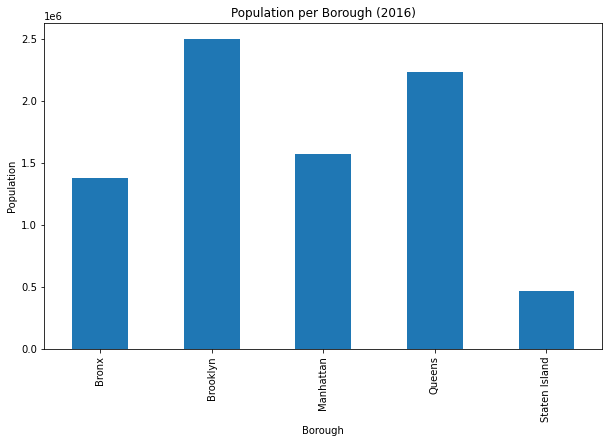

In [192]:
# Visualizing to see Borough with Highest Population
df.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Population per Borough (2016)') # add title to the plot

plt.show()

 <font size="3"> From the above bar chart, it can be seen that Brooklyn has the highest population value. This means that the target borough for the location is Brooklyn, The next thing to do is to go through some steps to determine where exactly in Brooklyn can we find the location of the restaurant.</font>

## Methodology <a name="methodology"></a>

The overall goal is to target a location where Italian Restaurants are the most common venues and restaurants are a common business. Such locations will be grouped together then evaluated.
    
In the first step, datasets were downloaded, converted to pandas dataframes and  the borough with the highest population was determined.    

The second step is to analyze each and every neighboorhood.This will be for 100 most popular spots within a 500m radius. From these neighborhoods, a list of all restaurants will be extracted. Frequency of occurance of each  restaurant will be visualized

The third step is to apply a machine learning algorithm,K-means clustering to these restaurants and group them into clusters. 

The fourth step is to find the first 10 Most Common Venues amongst these restaurants

Then each and every cluster will be analyzed. The analysis will involve
* Number of restaurants in a cluster
* Number of Italian Restaurants in a cluster
* Are Italian Restaurants common venues in that cluster



 <font size="3"> Let's first extract Brooklyn data only and  use geopy library to get coordinates for Brooklyn. </font>

In [14]:
#extracting Brooklyndata only
brooklyn_data = new_york[new_york['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [15]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


 <font size="3"><h1> Using Foursquare to get venue and category information</h1></font>
     <font size="3">  Foursquare is a social location service that allows users to explore the world around them. The Foursquare API will be used to get the venue and category information..</font>

In [16]:
#Foursquare Credentials and Version
client_id = '21MWAQ0OAOF2KFBZ5DS1Y15C3HMEPLOQSKIMXKURGJA1TGNE' # your Foursquare ID
client_secret = 'AULST3BFPQUXEIZ2DSHGFDSVCE1X2QDTVWARCY4VZBOFY0R3' # your Foursquare Secret
VERSION = '20190530' # Foursquare API version

In [17]:
#Exploring first neighborhood
brooklyn_data.loc[0, 'Neighborhood']

'Bay Ridge'

Now will retrieve the 100 most popular spots for each neighborhood,within 500m radius

In [18]:
radius = 500
limit = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(client_id, client_secret, latitude, longitude, VERSION, radius, limit)

In [19]:
res = requests.get(url).json()
res

{'meta': {'code': 200, 'requestId': '5ff42dd9ac6001401034c4de'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Flatbush',
  'headerFullLocation': 'Flatbush, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 30,
  'suggestedBounds': {'ne': {'lat': 40.6546038045, 'lng': -73.94366218526689},
   'sw': {'lat': 40.645603795499994, 'lng': -73.95550241473312}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b53503bf964a520d29627e3',
       'name': 'Exquisite Delight',
       'location': {'address': '2847 Church Ave',
        'crossStreet': 'at Nostrand Ave',
        'lat': 40.64909065673373,
        'lng': -73.94924266662322,
        'labeledLatLngs': [{'label': '

In [20]:
#Function to get category of venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
import json 
from pandas.io.json import json_normalize

In [22]:
venues = res['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-22-e7f95331d398>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Exquisite Delight,Caribbean Restaurant,40.649091,-73.949243
1,Jus Juice,Juice Bar,40.652208,-73.949723
2,Nostrand Health Foods,Juice Bar,40.649092,-73.949243
3,"Courts (Furniture, Electronics, & Appliances)",Furniture / Home Store,40.650436,-73.950608
4,Tastee Pattee,Caribbean Restaurant,40.650850,-73.947838


In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

30 venues were returned by Foursquare.


<font size="3"> Let's explore neighborhoods in Brooklyn</font>

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

In [26]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2766, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant
3,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
4,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar


It can be seen that there are 2766 venues in Brooklyn.

Let's see how many venues are in each neighborhood  and a total of all the unique venue category just to get an insight from our data

In [206]:
#Venues returned by each neighborhood
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,43,43,43,43,43,43
Bay Ridge,78,78,78,78,78,78
Bedford Stuyvesant,29,29,29,29,29,29
Bensonhurst,29,29,29,29,29,29
Bergen Beach,8,8,8,8,8,8
Boerum Hill,91,91,91,91,91,91
Borough Park,22,22,22,22,22,22
Brighton Beach,42,42,42,42,42,42
Broadway Junction,18,18,18,18,18,18


In [29]:
#Unique categories
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))


There are 288 uniques categories.


## Analysis <a name="analysis"></a>

Will start by using one hot encoding on our venue data so that it can be parsed to a machine learning algorithm. We want to find the 10 most common venues in a neighborhood, just to see if restaurants are amongst common venues. Later on, will group restaurants together and do the same analysis on restaurants, that is, to see the 10 most common venues that are restaurants in a neighborhood as well as the type of the restaurant.

In [30]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Gym,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turk

<font size="3">Next, let's group rows by neighborhood and by taking the mean of the frequency for each category</font>

In [31]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Gym,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turk

<font size="3">Let's find the 10 most common  venues </font>

In [32]:
#Find 10 most common venues in each neighborhood



def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pizza Place,Chinese Restaurant,Bubble Tea Shop,Gas Station,Pharmacy,Donut Shop,Fast Food Restaurant,Italian Restaurant,Sandwich Place,Burger Joint
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Chinese Restaurant,Bagel Shop,Bar,American Restaurant,Greek Restaurant,Ice Cream Shop,Hookah Bar
2,Bedford Stuyvesant,Deli / Bodega,Coffee Shop,Pizza Place,Café,Bar,Thrift / Vintage Store,Playground,Park,Cocktail Bar,New American Restaurant
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Park,Ice Cream Shop,Donut Shop,Sushi Restaurant,Cha Chaan Teng,Grocery Store,Coffee Shop,Bar
4,Bergen Beach,Harbor / Marina,Baseball Field,Park,Playground,Athletics & Sports,Field,Factory,Falafel Restaurant,Farm,Farmers Market


By just a mere look at the above dataset, one can see that restaurants are amongst the top 10 Most Common Venues. This shows that, in Brooklyn restaurants are a common business.

Now, let's extraxt restaurants only to make  our analysis more specific. We want to get all the restaurants in the neighborhood and do the same analysis as we did on neighborhoods. 
In addition, we will group the restaurants into clusters so that each cluster can be further analyzed.

In [34]:
#getting list of all restaurants in queens
contain_values = brooklyn_venues[brooklyn_venues['Venue Category'].str.contains('Restaurant')]
contain_values

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant
7,Bay Ridge,40.625801,-74.030621,Blue Door Souvlakia,40.624567,-74.030311,Greek Restaurant
12,Bay Ridge,40.625801,-74.030621,Karam,40.622931,-74.028316,Middle Eastern Restaurant
13,Bay Ridge,40.625801,-74.030621,Elia Restaurant,40.623090,-74.031156,Greek Restaurant
17,Bay Ridge,40.625801,-74.030621,Tuscany Grill,40.622913,-74.031387,Italian Restaurant
22,Bay Ridge,40.625801,-74.030621,Zio Toto,40.624791,-74.030551,Italian Restaurant
26,Bay Ridge,40.625801,-74.030621,Greenhouse Cafe,40.629542,-74.028514,American Restaurant
28,Bay Ridge,40.625801,-74.030621,XIN,40.625082,-74.030494,Chinese Restaurant
29,Bay Ridge,40.625801,-74.030621,Chadwick's Restaurant,40.621450,-74.031964,American Restaurant
30,Bay Ridge,40.625801,-74.030621,Cebu' Bar & Bistro,40.621812,-74.031727,New American Restaurant


In [35]:
#group restaurants by Venue Category
restaurants=contain_values.groupby('Venue Category')
restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant
7,Bay Ridge,40.625801,-74.030621,Blue Door Souvlakia,40.624567,-74.030311,Greek Restaurant
12,Bay Ridge,40.625801,-74.030621,Karam,40.622931,-74.028316,Middle Eastern Restaurant
13,Bay Ridge,40.625801,-74.030621,Elia Restaurant,40.623090,-74.031156,Greek Restaurant
17,Bay Ridge,40.625801,-74.030621,Tuscany Grill,40.622913,-74.031387,Italian Restaurant
22,Bay Ridge,40.625801,-74.030621,Zio Toto,40.624791,-74.030551,Italian Restaurant
26,Bay Ridge,40.625801,-74.030621,Greenhouse Cafe,40.629542,-74.028514,American Restaurant
28,Bay Ridge,40.625801,-74.030621,XIN,40.625082,-74.030494,Chinese Restaurant
29,Bay Ridge,40.625801,-74.030621,Chadwick's Restaurant,40.621450,-74.031964,American Restaurant
30,Bay Ridge,40.625801,-74.030621,Cebu' Bar & Bistro,40.621812,-74.031727,New American Restaurant


The next thing is to visualize the frequency of each type of restaurant and see the most common restaurant in Brooklyn. Will first create a dataframe with the total number of each type of restaurant and then use this to create a bar chart.

In [36]:
#drop unneccessary columns
df1=contain_values.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude'],axis=1)

In [121]:
#create dataframe
df2=df1.groupby('Venue Category').size().reset_index(name='Count')

df3=df2.sort_values("Count", ascending=False)
df4=df3.head(10)
df4


,Venue Category,Count
27,Italian Restaurant,69
10,Chinese Restaurant,55
33,Mexican Restaurant,49
0,American Restaurant,40
8,Caribbean Restaurant,34
40,Restaurant,32
48,Sushi Restaurant,30
28,Japanese Restaurant,27
52,Thai Restaurant,25
17,Fast Food Restaurant,23


In [122]:
#set index
df4.set_index("Venue Category",drop=True,inplace=True)
df4

,Count
Venue Category,
Italian Restaurant,69
Chinese Restaurant,55
Mexican Restaurant,49
American Restaurant,40
Caribbean Restaurant,34
Restaurant,32
Sushi Restaurant,30
Japanese Restaurant,27
Thai Restaurant,25


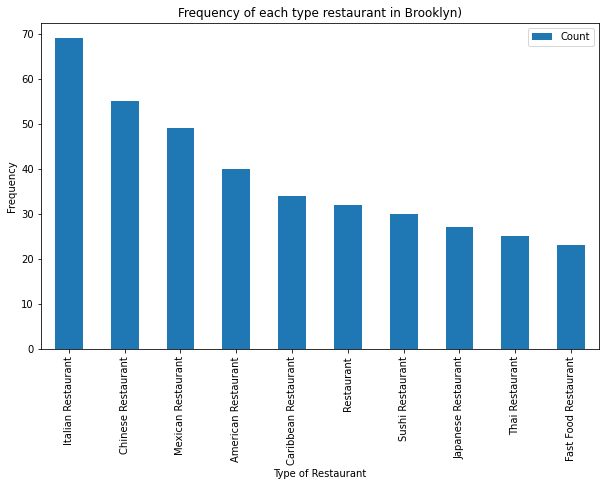

In [125]:
#Plot bar chart 
df4.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Type of Restaurant') # add to x-label to the plot
plt.ylabel('Frequency') # add y-label to the plot
plt.title('Frequency of each type restaurant in Brooklyn)') # add title to the plot
plt.show()

Surprisingly, from the bar chart above, it can be seen that Italian Restaurants have the highest number in Brooklyn!This means probably there are a lot of people who like Italian food in Brooklyn. A good market!

Now, it's time to cluster the restaurants. we will start by one hot encoding on our dataframe. Then we will group the restaurants by neighborhood and find the mean frequency. After this will find the 10 most common restaurants in a neighborhood. We will then cluster these for further analysis. I will use the elbow method to determine the best value for k when clustering.

In [40]:
# one hot encoding
restaurants_onehot = pd.get_dummies(contain_values[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
restaurants_onehot['Neighborhood'] = contain_values['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [restaurants_onehot.columns[-1]] + list(restaurants_onehot.columns[:-1])
restaurants_onehot = restaurants_onehot[fixed_columns]

restaurants_onehot.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Pakistani Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
2,Bay Ridge,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
restaurants_grouped = restaurants_onehot.groupby('Neighborhood').mean().reset_index()
restaurants_grouped

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Pakistani Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bath Beach,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.166667,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.111111,0.00,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.055556,0.055556,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000
1,Bay Ridge,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.111111,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.00,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.037037,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.037037,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.037037
2,Bedford Stuyvesant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bensonhurst,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Boerum Hill,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.214286,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000
5,Borough Park,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.333333,0.00,0.000000,0.000000,0.000000,0.

In [42]:
#Find 10 most common restaurants in each neighborhood



def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_restaurants_sorted = pd.DataFrame(columns=columns)
neighborhoods_restaurants_sorted['Neighborhood'] = restaurants_grouped['Neighborhood']

for ind in np.arange(restaurants_grouped.shape[0]):
    neighborhoods_restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(restaurants_grouped.iloc[ind, :], num_top_venues)

neighborhoods_restaurants_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Pakistani Restaurant,Dim Sum Restaurant,Middle Eastern Restaurant,Russian Restaurant,Cantonese Restaurant,Sushi Restaurant
1,Bay Ridge,Italian Restaurant,American Restaurant,Chinese Restaurant,Greek Restaurant,Sushi Restaurant,Seafood Restaurant,Caucasian Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Indian Restaurant
2,Bedford Stuyvesant,Japanese Restaurant,New American Restaurant,Italian Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Eastern European Restaurant,Indian Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
4,Boerum Hill,French Restaurant,Middle Eastern Restaurant,Cajun / Creole Restaurant,Indian Restaurant,Seafood Restaurant,Chinese Restaurant,Mexican Restaurant,Japanese Restaurant,Halal Restaurant,Thai Restaurant


In [44]:
#Putting Restaurants into clusters
restaurants_clustering = restaurants_grouped.drop('Neighborhood', 1)

Let's run the Elbow method to determine the optimum value for k

In [90]:
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(restaurants_clustering)
        distortions.append(kmeanModel.inertia_)

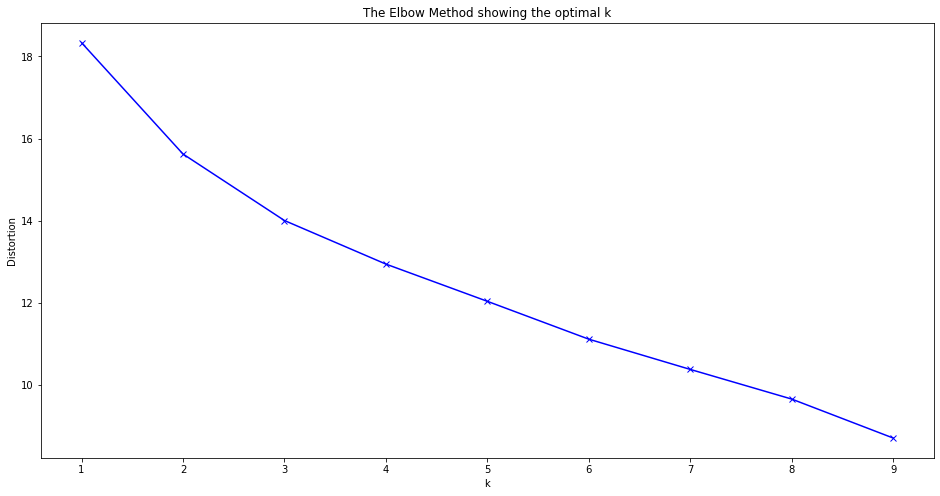

In [91]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the Elbow method above, an optimum value k=3 is obtained and will therefore be used for the numberv of clusters

In [93]:
# run k-means clustering
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_clustering)
kmeans.labels_[0:10]

array([1, 1, 1, 0, 1, 1, 1, 2, 1, 0], dtype=int32)

In [94]:
#add clustering labels
neighborhoods_restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

rest_merged = brooklyn_data

# merge  to add latitude/longitude for each neighborhood
rest_merged = brooklyn_data.join(neighborhoods_restaurants_sorted.set_index('Neighborhood'), on='Neighborhood')

#neighborhoods_restaurants_sorted.head() 
rest_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1.0,Italian Restaurant,American Restaurant,Chinese Restaurant,Greek Restaurant,Sushi Restaurant,Seafood Restaurant,Caucasian Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Indian Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0.0,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Eastern European Restaurant,Indian Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,1.0,Latin American Restaurant,Mexican Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
3,Brooklyn,Greenpoint,40.730201,-73.954241,1.0,French Restaurant,Restaurant,Mexican Restaurant,Sushi Restaurant,Polish Restaurant,Vietnamese Restaurant,Chinese Restaurant,Indian Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,0.0,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
5,Brooklyn,Brighton Beach,40.576825,-73.965094,1.0,Russian Restaurant,Restaurant,Eastern European Restaurant,Sushi Restaurant,Korean Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
6,Brooklyn,Sheepshead Bay,40.586890,-73.943186,1.0,Turkish Restaurant,American Restaurant,Restaurant,Russian Restaurant,Italian Restaurant,Asian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,0.0,Japanese Restaurant,Eastern European Restaurant,Chinese Restaurant,Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
8,Brooklyn,Flatbush,40.636326,-73.958401,2.0,Mexican Restaurant,Caribbean Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
9,Brooklyn,Crown Heights,40.670829,-73.943291,1.0,Sushi Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant,French Restaurant


In [95]:
# dro na values
rest_merged=rest_merged.dropna( )

In [96]:
#casting cluster values to integers
rest_merged['Cluster Labels'] = rest_merged['Cluster Labels'].astype(int)
rest_merged.head()

<ipython-input-96-a9759520467a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_merged['Cluster Labels'] = rest_merged['Cluster Labels'].astype(int)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1,Italian Restaurant,American Restaurant,Chinese Restaurant,Greek Restaurant,Sushi Restaurant,Seafood Restaurant,Caucasian Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Indian Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Eastern European Restaurant,Indian Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,1,Latin American Restaurant,Mexican Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
3,Brooklyn,Greenpoint,40.730201,-73.954241,1,French Restaurant,Restaurant,Mexican Restaurant,Sushi Restaurant,Polish Restaurant,Vietnamese Restaurant,Chinese Restaurant,Indian Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,0,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant


The above output is what we obtain, restaurants that are within the ten Most Common Venues in Brooklyn. These neighborhoods are of interest because they show a good clientele for restaurants in general.

Let' visualize these clusters on a map. The map is created using folium

In [99]:
#create map
#create map
mp_cluster = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for  lon,lat,poi, cluster in zip(
      rest_merged['Latitude'], 
      rest_merged['Longitude'], 
      rest_merged['Neighborhood'], 
      rest_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mp_cluster)
       
mp_cluster

Let's now analyze each and every cluster.Our analysis will be based on the following:
* number of Italian Restaurant in a cluster
* Total number of Restaurants in a cluster
* Is an Italian Restaurant one of the common venues in the cluster?


In [100]:
#Cluster 1
df5=neighborhoods_restaurants_sorted.loc[neighborhoods_restaurants_sorted['Cluster Labels'] == 0, neighborhoods_restaurants_sorted.columns[[1] + list(range(2, neighborhoods_restaurants_sorted.shape[1]))]]

In [101]:
df5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Eastern European Restaurant,Indian Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
9,Brownsville,Chinese Restaurant,Restaurant,Spanish Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant,French Restaurant
11,Canarsie,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
19,Ditmas Park,Chinese Restaurant,Caribbean Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Ramen Restaurant,Tapas Restaurant,Tibetan Restaurant,Greek Restaurant,German Restaurant
22,East Flatbush,Chinese Restaurant,Caribbean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
34,Gravesend,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
40,Manhattan Terrace,Japanese Restaurant,Eastern European Restaurant,Chinese Restaurant,Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
41,Marine Park,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant,French Restaurant
42,Mill Basin,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Italian Restaurant,Middle Eastern Restaurant,Peruvian Restaurant,American Restaurant,Szechuan Restaurant,Dim Sum Restaurant,Halal Restaurant
43,New Lots,Asian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant


In [102]:
#Finding if Italian Restaurant is the 1st most common resturant in the cluster
df5.loc[df5['1st Most Common Venue']=='Italian Restaurant']

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Gravesend,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant


In Gravesend, an Italian Restaurant is the most common venue.

In [103]:
#Findind number of Italian Restaurants in a cluster

df5[df5 == 'Italian Restaurant'].count()


Neighborhood              0
1st Most Common Venue     1
2nd Most Common Venue     1
3rd Most Common Venue     0
4th Most Common Venue     1
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

The total number of Italian Restaurants in cluster 1 is only 3.

In [105]:
#Cluster 2
df6=neighborhoods_restaurants_sorted.loc[neighborhoods_restaurants_sorted['Cluster Labels'] == 1, neighborhoods_restaurants_sorted.columns[[1] + list(range(2, neighborhoods_restaurants_sorted.shape[1]))]]

In [106]:
df6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Pakistani Restaurant,Dim Sum Restaurant,Middle Eastern Restaurant,Russian Restaurant,Cantonese Restaurant,Sushi Restaurant
1,Bay Ridge,Italian Restaurant,American Restaurant,Chinese Restaurant,Greek Restaurant,Sushi Restaurant,Seafood Restaurant,Caucasian Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Indian Restaurant
2,Bedford Stuyvesant,Japanese Restaurant,New American Restaurant,Italian Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
4,Boerum Hill,French Restaurant,Middle Eastern Restaurant,Cajun / Creole Restaurant,Indian Restaurant,Seafood Restaurant,Chinese Restaurant,Mexican Restaurant,Japanese Restaurant,Halal Restaurant,Thai Restaurant
5,Borough Park,Fast Food Restaurant,American Restaurant,Eastern European Restaurant,Chinese Restaurant,Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
6,Brighton Beach,Russian Restaurant,Restaurant,Eastern European Restaurant,Sushi Restaurant,Korean Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant
8,Brooklyn Heights,Italian Restaurant,Asian Restaurant,Thai Restaurant,Indian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant
10,Bushwick,Mexican Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Chinese Restaurant,Italian Restaurant,Latin American Restaurant,Mediterranean Restaurant,French Restaurant,New American Restaurant,Fast Food Restaurant
12,Carroll Gardens,Italian Restaurant,Thai Restaurant,French Restaurant,Japanese Restaurant,Seafood Restaurant,Dumpling Restaurant,Filipino Restaurant,Greek Restaurant,Latin American Restaurant,Restaurant
13,City Line,Latin American Restaurant,Mexican Restaurant,South American Restaurant,Fast Food Restaurant,Cuban Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant


In [107]:
#Finding if Italian Restaurant is the 1st most common venue in each cluster
df6.loc[df6["1st Most Common Venue"]=='Italian Restaurant']


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bay Ridge,Italian Restaurant,American Restaurant,Chinese Restaurant,Greek Restaurant,Sushi Restaurant,Seafood Restaurant,Caucasian Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Indian Restaurant
8,Brooklyn Heights,Italian Restaurant,Asian Restaurant,Thai Restaurant,Indian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant
12,Carroll Gardens,Italian Restaurant,Thai Restaurant,French Restaurant,Japanese Restaurant,Seafood Restaurant,Dumpling Restaurant,Filipino Restaurant,Greek Restaurant,Latin American Restaurant,Restaurant
14,Clinton Hill,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Restaurant,Indian Restaurant,Mexican Restaurant,Caribbean Restaurant,Chinese Restaurant,Sushi Restaurant,Cajun / Creole Restaurant
15,Cobble Hill,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,French Restaurant,Mediterranean Restaurant,New American Restaurant,Restaurant,Argentinian Restaurant
28,Fort Greene,Italian Restaurant,French Restaurant,Vietnamese Restaurant,Seafood Restaurant,Caribbean Restaurant,Cuban Restaurant,German Restaurant,Indian Restaurant,Israeli Restaurant,Vegetarian / Vegan Restaurant
33,Gowanus,Italian Restaurant,Chinese Restaurant,American Restaurant,Mexican Restaurant,Argentinian Restaurant,Thai Restaurant,Ramen Restaurant,Brazilian Restaurant,Sushi Restaurant,Indian Restaurant
48,Park Slope,Italian Restaurant,Vietnamese Restaurant,Seafood Restaurant,Caribbean Restaurant,Chinese Restaurant,French Restaurant,Korean Restaurant,Mexican Restaurant,Ramen Restaurant,Japanese Restaurant


It can be seen that in Cluster 2, in a total of eight neigborhoods, Italian restaurant is the 1st Most Common Venue. This means Italian food is popular in this cluster.

In [108]:
#Findind number of Italian Restaurants in a cluster

df6[df6 == 'Italian Restaurant'].count()

Neighborhood              0
1st Most Common Venue     8
2nd Most Common Venue     5
3rd Most Common Venue     5
4th Most Common Venue     1
5th Most Common Venue     3
6th Most Common Venue     1
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     1
10th Most Common Venue    1
dtype: int64

<font size='3'>There are a total of 25 Italian Restaurant in this cluster. 

In [109]:
#Cluster 3
df7=neighborhoods_restaurants_sorted.loc[neighborhoods_restaurants_sorted['Cluster Labels'] == 2, neighborhoods_restaurants_sorted.columns[[1] + list(range(2, neighborhoods_restaurants_sorted.shape[1]))]]

In [110]:
df7

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Broadway Junction,Seafood Restaurant,Caribbean Restaurant,Dumpling Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant,French Restaurant
16,Coney Island,Caribbean Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant,French Restaurant
25,Erasmus,Caribbean Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
26,Flatbush,Mexican Restaurant,Caribbean Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
27,Flatlands,Caribbean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
51,Prospect Park South,Caribbean Restaurant,Fast Food Restaurant,Latin American Restaurant,Mexican Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant
53,Remsen Village,Caribbean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
54,Rugby,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Dumpling Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant
58,Starrett City,American Restaurant,Caribbean Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Halal Restaurant,Greek Restaurant,German Restaurant,French Restaurant


In [111]:
#Finding if Italian Restaurant is the 1st most common venue in the cluster
df7.loc[df7['1st Most Common Venue']=='Italian Restaurant']

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


No Italian restaurant is the 1st Most Common Venue in this cluster

In [112]:
#Findind number of Italian Restaurants in a cluster

df7[df7 == 'Italian Restaurant'].count()

Neighborhood              0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

There are no Italian Restaurant in cluster 3

<font size='3'> <h1>Results and Discussion</h1></font>
From the above analysis, it was observed that restaurants are definitely a common business in  Brooklyn. This is supported by the fact that more that 90% of people love to spoil themselves with food. This research was a market driven idea. The idea was to find a location where restaurants and Italian Restaurants are a very common business. Therefore, the Brooklyn was chosen based on its highest population (implying more demographics factors). The next thing was to cluster restaurants and an analysis was made from the clusters. 

Cluster 2 had the highest number of Italian restaurants and eight of them were in the 1st Most Common Venue. This cluster clearly shows that Italian food is common, probably there are a lot of Italian food lovers in the cluster. Moreover, having a lot of Italian restaurants in it means there is already a ready market for Italian food. Neighborhoods in which an Italian Restaurant was the 1st most common venue can be considered as potential locations for the restaurant.

Of course, it doesn't mean that the approach used in this project is the best way to find a location for a restaurant. There are other factors that can be considered such as,general air and environmental pollution, quietness of the neighborhood, age groups in the neighborhood, distance of neighborhood from central point, etc. However, from a clientele perspective, it is wiser to start a business where a market already exists and survival will depend on quality of services offered.

<font size='3'> <h1>Conclusion</h1></font>
The main objective of the project was to find a location for an Italian restaurant in New York City, uding Foursquare API. The most populated borough, Brooklyn was used for analysis. All restaurants were grouped into three clusters using k-means clustering and each cluster was analysed. This approach alongside others, can be used to find the location for a new restaurant.